In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,ZeroPadding2D

import cv2
import numpy as np         
import os                  
from tqdm import tqdm

In [2]:
import os
import pandas as pd
import zipfile
from google.colab import drive
drive.mount('/content/drive')
local_zip = '/content/drive/My Drive/DL Assignments/Project files/Student Projects.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Celosia_path= '/content/CELOSIA ARGENTEA L'
Crowfoot_path= '/content/CROWFOOT GRASS'
Chloris_path= '/content/PURPLE CHLORIS'

In [4]:
IMG_SIZE=227
labels=[]

In [5]:
def image_read(TRAIN_DIR):
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path)
        if img is not None:
          img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
          img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
          training_data.append(np.array(img))
    return training_data

In [6]:
def labelss(data,class_value):
  y=np.ones(len(data),dtype=int)*class_value
  return y

In [7]:
from keras import backend as K
import math

def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

In [8]:
alexnet = Sequential()

# Layer 1
alexnet.add(Conv2D(96, (11, 11), input_shape=(227,227,3), padding='same'))
alexnet.add(BatchNormalization())
conv1=Activation('relu')
alexnet.add(conv1) 
max_pool_1=MaxPooling2D(pool_size=(2, 2))
alexnet.add(max_pool_1)

# Layer 2
alexnet.add(Conv2D(256, (5, 5), padding='same'))
alexnet.add(BatchNormalization())
conv2=Activation('relu')
alexnet.add(conv2)
max_pool_2=MaxPooling2D(pool_size=(2, 2))
alexnet.add(max_pool_2)

# Layer 3
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(512, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

# Layer 5
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
max_pool_5=MaxPooling2D(pool_size=(2, 2))
alexnet.add(max_pool_5)

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(512))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(512))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 8
alexnet.add(Dense(3))
alexnet.add(BatchNormalization())
alexnet.add(Activation('softmax'))

In [9]:
alexnet.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [10]:
Celosia_data=image_read(Celosia_path)
Chloris_data=image_read(Chloris_path)
Crowfoot_data=image_read(Crowfoot_path)

100%|██████████| 60/60 [00:00<00:00, 266.48it/s]


In [11]:
Celosia_label=labelss(Celosia_data,1)
Chloris_label=labelss(Chloris_data,2)
Crowfoot_label=labelss(Crowfoot_data,0)

In [12]:
dataset=np.concatenate((Celosia_data,Chloris_data,Crowfoot_data))

In [13]:
class_labels=np.concatenate((Celosia_label,Chloris_label,Crowfoot_label))

In [14]:
dataset.shape

(193, 227, 227, 3)

In [15]:
class_labels.shape

(193,)

In [16]:
import sklearn.model_selection as ms

In [17]:
x_train,x_test,y_train,y_test=ms.train_test_split(dataset,class_labels,test_size=0.3,random_state=121123451)


In [18]:
from tensorflow.keras.utils import to_categorical
y_train_onehot= to_categorical(y_train)
y_test_onehot=to_categorical(y_test)

shape: (1, 33, 33, 1024)  min: -35.16523361206055  max: 35.59686279296875


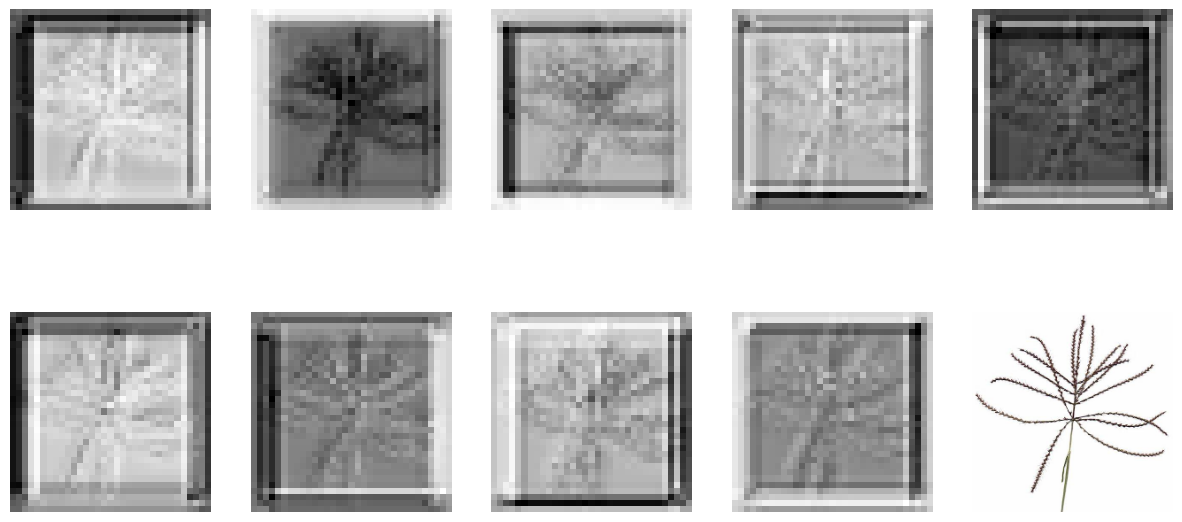

In [19]:
import matplotlib.pyplot as plt
img_to_visualize =x_test[57]
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)
view_layer(alexnet, img_to_visualize , "conv2d_4")
plt.imshow(x_test[57])

In [20]:
history=alexnet.fit(x_train[0:10], y_train_onehot[0:10], batch_size=8, epochs=10, validation_split=0.1, shuffle=True)

Epoch 1/10


KeyboardInterrupt: ignored